# LSH for Plagiarism Detection 

Vedang Mondreti (vm2129@nyu.edu) $\hspace{10mm}$     Vishal Prakash (vp2181@nyu.edu)

## Introduction

Plagiarism is a widespread issue in today's age of information. It refers to the unauthorized usage of another author's work and representing it as one's own effort without providing due credit. Plagiarism can occur in various mediums like websites, music, video and imaging and professional documents. The extent of plagiarism can also vary from minor modification of another work to outright copying. Nowadays we have instruments such a copyrights that enable one to take legal action if any evidence of plagiarism is found. To make use of such facilities, we must be able to identify cases of malpractice. We can identify these cases by simply comparing content with each other. But given the scale of information we produce nowadays, it is not feasible to manually compare content with each other using simple comparison as the time and energy requirements would be large. Hence the scientfic community has put in significant effort to design and produce efficient solutions to quickly identify cases of plagiarism at scale.

Plagiarism among text and image based document is an important issue that the scientific community faces very often. Given that there is large amount of intellectual property being published, effort is made to catch cases of plagiarism to respect the efforts put in by researchers. There are several solutions that have been developed to scan through large directories of documents and pin point cases which show signs of plagiarism.

To show why we need efficient solutions that avoid comparing documents one-by-one with each other, assuming we have a large number of documents say n. If we need to compare the similarity between each and every pair, we will need to make $n(n-1)/2$ comparisons. This leads to a time complexity of $O(n^2)$ which is not advisable for a large number of documents. Additionally, to represent a document, we tend to convert documents into single dimension arrays which tell us whether a single word/character or a sequence of words/characters are present in a document along with their frequencies. It is these arrays which we compare when matching pairs of documents. However these arrays tend to be sparse which leads to large memory consumption. Hence efforts have been made to reduce the memory requirements of these naive methods.

Min-Hashing and Locality Sensitive Hashing (LSH) are two algorithms that can be used to reduce the time and space consumed to efficiently and quickly identify documents which show high levels of similarity.

In this project, we attempt to make use of these two algorithm to develop a plagiarism detector. Given a list of of original documents, the solution will learn the text corpus representing these documents. We then provide a list of documents which may or may not be duplicates of these original "source" documents. The "suspicious" documents are then compared with the source files and tagged as plagiarism if the level of similarity exceeds a threshold.

#### Dataset
The dataset we are using has been obtained from https://data.mendeley.com/datasets/gz3hztwm5p/1 which was put together to help the research community develop techniques to detect plagiarism in documents containing images and their associated text. The intuition here is that if an image in a document has been plagiarised, the text pertaining to the image should also be similar. This text includes the caption below the image and text in the main paragraphs that refer to the image. The dataset also includes text which explains the structure of the image but this has not been used as a part of the project. There are 122 source text files, one each for every source image, and 146 suspicious text files, one each for every suspicious image which may or may not be a plagiarism of one of the source images. We also have an annotation .xml file for each suspicious file which tells us whether the suspicious image is truely a plagiarism or not.

#### Process Flow of Project
The steps we followed to implement the project are as follows:

- Data pre-processing such as reading in files and associated annotations
- File parsing and data extraction
- Converting text into sets using n-grams
- Min-hashing the document sets to smaller signatures
- LSH to find similar documents (images)
- Understanding performance

### Importing Libraries

In [2]:
from os import listdir
import pandas as pd
import re
import numpy as np
from nltk import ngrams
import re
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

Setting constants to be used later.

In [3]:
#constants
numhashes=1000

## Preprocessing

Reading in file paths for data digestion.

In [5]:
#Obtaining list of source, suspicious and annotation files
base_path=r"/Users/vishalprakash/Desktop/Final Project/Figure Plagiarism corpus/Textual reference based figure plagiarism/Source figures/"
files =[base_path+file for file in listdir(base_path) if file.endswith('.txt')]
files=sorted(files,key=str.lower)

path_sus = r"/Users/vishalprakash/Desktop/Final Project/Figure Plagiarism corpus/Textual reference based figure plagiarism/plagiarised figures/"
files_sus = [path_sus+file for file in listdir(path_sus) if file.endswith('.txt')]
files_sus=sorted(files_sus,key=str.lower)

path_labels = r"/Users/vishalprakash/Desktop/Final Project/Figure Plagiarism corpus/Textual reference based figure plagiarism/Annotations/"
files_labels = [path_labels+file for file in listdir(path_labels) if file.endswith('.xml')]
files_labels=sorted(files_labels,key=str.lower)

#Confirming we have read in files
print('Number of Source Files:',len(files))
print('Number of Suspicious Files:',len(files_sus))
print('Number of Annotations:',len(files_labels))

Number of Source Files: 122
Number of Suspicious Files: 170
Number of Annotations: 146


The annotation data will be used later to tell us how well Min-hashing and LSH helped in identifying whether a suspicious file was a plagiarism or not. The data gives us information such as whether the suspicious image was a plagiarism. If it was, which source image was it plagiarised from and the type of plagiarism.

In [4]:
#Parsing annotation files to obtains labels for each suspicious file
labels_col_names= ["Reference", "Source_Reference","Plag_Type", "Obfuscation"]
labels_df = pd.DataFrame(columns = labels_col_names)

for file in files_labels:
    parsed = ET.parse(file)
    root = parsed.getroot()
    temp_df = pd.DataFrame(columns = labels_col_names)
    if root[1].attrib["plag_type"] == "Free Plagiarism":
        temp_df = temp_df.append(pd.Series([root[0].attrib["reference"], "", root[1].attrib["plag_type"], ""], index = labels_col_names), ignore_index=True)
    else:
        temp_df = temp_df.append(pd.Series([root[0].attrib["reference"], root[1].attrib["source_reference"], root[1].attrib["plag_type"], root[1].attrib["obfuscation"]], index = labels_col_names), ignore_index=True)   
    
    temp_df['Reference_clean'] = temp_df['Reference']
    temp_df.iloc[0,4] = re.sub(r"\s", "_", temp_df.iloc[0,4])
    temp_df.iloc[0,4] = re.sub(r"__", "_", temp_df.iloc[0,4])
    temp_df.iloc[0,4] = re.sub(r"xml", "txt", temp_df.iloc[0,4])
    temp_df.iloc[0,4] = temp_df.iloc[0,4].lower()
    
    temp_df['Source_Reference_clean'] = temp_df['Source_Reference']
    temp_df.iloc[0,5] = re.sub(r"\s", "_", temp_df.iloc[0,5])
    temp_df.iloc[0,5] = re.sub(r"__", "_", temp_df.iloc[0,5])
    temp_df.iloc[0,5] = re.sub(r"xml", "txt", temp_df.iloc[0,5])
    temp_df.iloc[0,5] = temp_df.iloc[0,5].lower()
    
    labels_df = pd.concat([labels_df,temp_df])

labels_df = labels_df.reset_index(drop=True)
labels_df

,Reference,Source_Reference,Plag_Type,Obfuscation,Reference_clean,Source_Reference_clean
0,SuspiciousRelated 54_00.xml,SourceRelated_54_00.txt,Exact copy,none,suspiciousrelated_54_00.txt,sourcerelated_54_00.txt
1,SuspiciousRelated 54_01.xml,SourceRelated_54_01.txt,Exact copy,none,suspiciousrelated_54_01.txt,sourcerelated_54_01.txt
2,SuspiciousRelated 54_02.xml,SourceRelated_54_02.txt,Exact copy,none,suspiciousrelated_54_02.txt,sourcerelated_54_02.txt
3,SuspiciousRelated 54_03.xml,SourceRelated_54_03.txt,Exact copy,none,suspiciousrelated_54_03.txt,sourcerelated_54_03.txt
4,SuspiciousRelated 54_04.xml,SourceRelated_54_04.txt,Exact copy,none,suspiciousrelated_54_04.txt,sourcerelated_54_04.txt
5,SuspiciousRelated 54_05.xml,SourceRelated_54_05.txt,Exact copy,none,suspiciousrelated_54_05.txt,sourcerelated_54_05.txt
6,SuspiciousRelated 55_00.xml,SourceRelated_55_00.txt,Exact copy,none,suspiciousrelated_55_00.txt,sourcerelated_55_00.txt
7,SuspiciousRelated 55_01.xml,SourceRelated_55_01.txt,Exact copy,none,suspiciousrelated_55_01.txt,sourcerelated_55_01.txt
8,SuspiciousRelated 56_00.xml,SourceRelated_56_00.txt,Text modification: Paraphrasing; rewrite text,Strong,suspiciousrelated_56_00.txt,sourcerelated_56_00.txt
9,SuspiciousRelated 57_00.xml,SourceRelated_57_00.txt,Exact copy,none,suspiciousrelated_57_00.txt,sourcerelated_57_00.txt


### File Parsing and Data Extraction

Text for every source and suspicious image is extracted from the corresponding .txt files. Basic text cleaning such as removal of special characters is done as they will not contribute much to similarity checking. They will also unnecessarily lead to enlongation of document arrays when creating the bag of words in the later stage.

In [5]:
#Extract text from a .txt file
def get_text(file_name):
    sample=open(file_name,encoding='iso-8859-1')
    content=sample.readlines()
    content=[item.replace('\n','') for item in content]
    text=' '.join(content)
    return text

#Extract filename from file_path
def get_file_name(file_path):
    return re.sub(r'^.*{}'.format(re.escape("/")), '', file_path, flags=re.DOTALL).strip()

#Clean the Text
def regex(txt):
    return re.sub(r"[^a-zA-Z0-9]", " ", txt.lower())

In [6]:
#Load all text files into Pandas Dataframe
def extract_data(files):
    col_names = ['text','fileName_orig','fileName'] #df_cols
    base_df = pd.DataFrame(columns = col_names)

    for file_path in files:
        fileName_orig = get_file_name(file_path)
        fileName = fileName_orig.lower()
        text=regex(get_text(file_path))
        df=pd.DataFrame([[text,fileName_orig,fileName]],columns=col_names)
        base_df = pd.concat([base_df,df])

    base_df = base_df.reset_index(drop=True)
    return base_df

### Loading Source Files and Suspicious Files

Data loading is done here. A sample of the dataframe structure is provided:

In [7]:
source_df=extract_data(files)
sus_df=extract_data(files_sus)

sus_df

,text,fileName_orig,fileName
0,figure 1 web object and object extraction ...,SuspiciousRelated_00_00.txt,suspiciousrelated_00_00.txt
1,fig 2 bearing condition monitoring systembou...,SuspiciousRelated_01_00.txt,suspiciousrelated_01_00.txt
2,fig 1 architecture development for the multi...,SuspiciousRelated_01_01.txt,suspiciousrelated_01_01.txt
3,fig 3 sample agent interactionthe other on t...,SuspiciousRelated_01_02.txt,suspiciousrelated_01_02.txt
4,fig 1 data collection and processing by the ...,SuspiciousRelated_02_00.txt,suspiciousrelated_02_00.txt
5,fig 6 recommendations generation based on on...,SuspiciousRelated_02_01.txt,suspiciousrelated_02_01.txt
6,figure 1 eirs system framework 00 2008 ie...,SuspiciousRelated_03_0.txt,suspiciousrelated_03_0.txt
7,figure 1 global hand posture detection and rec...,SuspiciousRelated_04_00.txt,suspiciousrelated_04_00.txt
8,figure 2 multi energy resource interactions ...,SuspiciousRelated_05_00.txt,suspiciousrelated_05_00.txt
9,fig 1 high level google architecture couple...,SuspiciousRelated_06_00.txt,suspiciousrelated_06_00.txt


## Step 1: Converting Documents to sets using n-grams

In order for the text to compared, we must convert it into a format that represents the content of the text. Here, we will be creating a bag of words to create a n-gram vector for each document. We have used a CountVectorizer to create the n-grams taking a value of n=2. A text corpus based on the source text files is created as a result which is a n-gram of all the content present in these source files. Using the same text corpus, n-gram vectors are created for the suspicious text files which will tell us how many of these n-grams are present in these files. This will then be used to compare documents.

N-grams of word size 2 was chosen in an effort to create an ideal balance between catching matching words and at the same time maintaining some information on word ordering.

In [8]:
#fit model to source text
#using 2-grams
n=2
vectorizer = CountVectorizer(stop_words='english',ngram_range=(n,n))
vectorizer_model = vectorizer.fit(source_df['text'])

def transform_data(model,df):
    X = model.transform(df['text'])
    df_bow = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
    df_bow.where(df_bow <= 1, 1, inplace=True)
    df_bow.index = list(df["fileName"])
    df_bow_T = df_bow.T
    return df_bow_T



In [36]:
source_df_bow=transform_data(vectorizer_model,source_df)
print('Dimension of Source Data Frame:',source_df_bow.shape)

sus_df_bow=transform_data(vectorizer_model,sus_df)
print('Dimension of Suspicious Data Frame:',sus_df_bow.shape)

Dimension of Source Data Frame: (19267, 122)
Dimension of Suspicious Data Frame: (19267, 170)


In [10]:
sample_bow=np.array(source_df_bow.iloc[:,1])
print(sample_bow)
print('Length of Document vector:',len(sample_bow))

[0 0 0 ... 0 0 0]
Length of Document vector: 19267


This is what an n-gram vector for a document looks like.

## Step 2: Min Hashing $\rightarrow $ Converting Large Sets to short Signatures

As We can see the, length of each document vector is pretty huge(19267). It can be expensive to compare two documents directly. The aim of this step is to convert these long document vectors into short signatures which can fit in memory. These signatures must preserve the similarity of documents. That is, if two documents are similar, then their corresponding signatures must also be similar.

We develop signatures of document by hashing the column multiple times and stringing the output values. This hash function is dependent on the similarity metric. We will be using Jaccard similarity to judge similiarity of documnents and Min-Hashing is a suitable hash function for Jaccard similiarity.

$$\text{Jaccard Similarity}= \frac{|D1\cap D2|}{|D1\cup D2|}$$

In Min Hashing,we randomly permute the rows of the n-gram vector. The min hash of a document for a given permutation i is the index of the first 1 in the document when permuted.

For a permutation $\pi$ and column vector c, The hash function $h_{\pi}(c)$ is defined as $$h_{\pi}(c)= min_{\pi}\pi(c) $$

We pick k such permutations to generate a signature of length k for a document. But permuting rows can be expensive. Hence we use the concept of row-hashing for one-pass implementation of min Hashing. We pick k hash functions of the form $h_{a,b}(x)=(ax+b)\mod n$ where n is the number of rows. We apply the hash functions row wise and update the signature matrix accordingly to generate the final signature matrix.

Since we wish to preserve similiarity of documents, we need to choose k to be large enough to decrease the expected error. At the same times, the signature should be small enough to fit in memory.

We use $1000$ permutations to generate min-hash signatures of length=$1000$ for each document, which is a $95\%$ smaller than the actual document vector.

In [11]:
num_shingles=source_df_bow.shape[0]
#using h(x)=ax+b%num_shingles 
#generating 1000 values for a and b
a_hash=np.random.choice(range(num_shingles),size=numhashes,replace=False)
b_hash=np.random.choice(range(num_shingles),size=numhashes,replace=False)

#Min-Hash Function which generates a 1000-integer signature for each document.
def min_hash(df,numhashes=1000,a=a_hash,b=b_hash):
    columns=df.shape[1]
    m=np.ones([numhashes,columns])*np.inf
    #row hashing
    for row in range(num_shingles):
        hash=[]
        for i in range(numhashes):
            value=(a[i]*row+b[i])%num_shingles
            hash.append(value)
    
        for column in range(columns):
            if df.iloc[row,column]==1:
                for i in range(numhashes):
                    if hash[i]<m[i][column]:
                        m[i][column]=hash[i]
    return m


Min-Hashing Source Files

In [13]:
source_df_min_hash=min_hash(source_df_bow,numhashes).astype(int) #REPLACED 1000 WITH NUMHASHES

In [14]:
def print_signature(doc_id):
    signature=source_df_min_hash[:,doc_id]
    return ('- '+' - '.join(map(str,signature[:5]))+' ... '+(' - '.join(map(str,signature[-5:])))+' -')
print('Signature of Document 0')
print(print_signature(0))
print('\nLength  of Signature:',len(source_df_min_hash[:,0]))

Signature of Document 0
- 311 - 5 - 149 - 8 - 15 ... 296 - 11 - 95 - 56 - 33 -

Length  of Signature: 1000


__This is how a document signature looks like.__

## Step 3: Locality Sensitive Hashing

The goal of Locality Sensitive Hashing is to find documents with a jaccard similarity $\ge 0.5$.

We do this by hashing the columns of the signature matrix to a large number of buckets, and only comparing the documents that hash onto the same bucket. The advantage of this method is that only small number of pairs of documents need to be checked. However, one drawback of LSH is that it produces false Negatives. That is two similar documents might not get hashed onto the same bucket, hence there's a chance of not catching plagiarised documents in our case.

In order to tackle false negatives, we divide the signature of the document into $b$ bands each containing $r$ rows and hash the bands into a large hash table. Then, we only examine those documents which share a bucket for atleast one of the hashings.

We Find the optimal value of $b,r$ for a. given threshold.

$Algorithm:$
For every possible value of r (i.e. from 1 to the total number of rows in the signature vector), we obtain the value of b using $1/\text{t}^r$. We then calculate $b*r$ to obtain the total number of possible rows across all bands. We want this value to be as close as possible to the number of rows in the signature matrix (the error). The b and r combination which gives us the least error is chosen.

In [15]:
def get_bands_rows(numhashes,threshold):
    min_error=np.inf
    best_r=-1
    for r in range(1,numhashes+1):
        try:
            b=1/(threshold**r)
        except ZeroDivisionError:
            b=np.inf

        error=abs(numhashes-b*r)
        if error < min_error:
            best_r=r
            min_error=error
    band= int(numhashes/best_r)
    return band,best_r

#Calculate band and row values for similiarity=0.5
lsh_bands,lsh_rows=get_bands_rows(numhashes,0.5)
print("Best Values:")
print('Bands:',lsh_bands,', Rows:',lsh_rows)

Best Values:
Bands: 142 , Rows: 7


Visualizing the s-curve using the obtained row and band values.

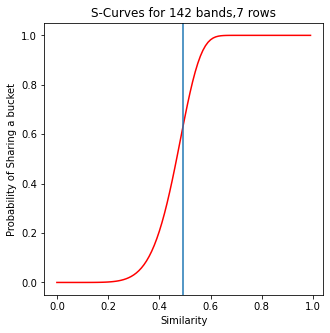

Threshold= [0.493]


In [109]:
r=np.array([lsh_rows])
b=(numhashes/r).astype(int)

s=np.arange(0,1,0.01)
y=np.zeros(len(s))

for i in range(len(r)):
    y=1-(1-s**r)**b
    
threshold=(1/b)**(1/r)

plt.figure(figsize=[5,5])
plt.plot(s,y,color='red')
plt.title('S-Curves for 142 bands,7 rows')
plt.xlabel('Similarity')
plt.ylabel('Probability of Sharing a bucket')
plt.axvline(threshold)
plt.show()
print('Threshold=',np.round(threshold,3)) 

We can see that by using 142 bands and 7 rows in each band, The documents which are more than 50% similar are ~60% likely to share a bucket and documents with >60% similarity are highly likely to share a bucket for atleast one of the bands.

The value of bands and rows are chosen to minimize the number of false negatives and false positives.

#### Steps in LSH ####
1. Hash signature matrix of source corpus into a hash table
2. Generate minhash signature for every suspicious document and hash it onto the same table.
3. Compare documents which hashed onto the same bucket.

In [16]:
def lsh_hash(x):
    x=np.array(x)
    return np.sum(x**2)%(2**63-1) #31

#building hash_table
#each row is a signature of a document
def lsh_corpus(signature_matrix_T,bands=20,rows=5):
    dictionary={}
    signature_matrix=signature_matrix_T.T
    
    for num,signature in enumerate(signature_matrix):
        for i in range(bands):
            # select a band
            mini_signature=signature[i*rows:(i+1)*rows]
            #hash the band
            hash_val=lsh_hash(mini_signature)
            if hash_val not in dictionary:
                dictionary[hash_val]=set()
            #insert document_number into hash table
            dictionary[hash_val].add(num)
    return dictionary

#Use lsh hash table to find documents with similar signatures
def generate_suspicious(dictionary,document,bands=20,rows=5):
    suspicious=set()
    for i in range(bands):
        mini_signature=document[i*rows:(i+1)*rows]
        hash_val=lsh_hash(mini_signature)
        if hash_val in dictionary:
            suspicious=suspicious.union(dictionary[hash_val])
    return suspicious

Building LSH Hash table using signature matrix of Source Documents:

In [18]:
lsh_dict=lsh_corpus(source_df_min_hash,lsh_bands,lsh_rows)
print("Number of different keys in the LSH dictionary:",len(lsh_dict))
print('\nDictionary Snapshot')
random_keys=np.random.choice([key for key in lsh_dict],size=5)
for key in random_keys:
    print(key,':',lsh_dict[key])

Number of different keys in the LSH dictionary: 16396

Dictionary Snapshot
153116 : {31}
192438 : {32}
12624 : {54}
194852 : {97}
45312 : {18, 6}


### Min Hashing the Suspicious files

After hashing all the source documents into bins (stored as a dictionary), we now know that if we hash a suspicious document to this dictionary, it will be placed in a bin along which contains other documents that are most likely to be similar to it. We can then perform a brute force comparison of the suspicious documents with the source documents present in the same bin to figure out the true similarity and hence whether it is a plagiarism.

In order to hash a suspicious document to the dictionary, we must repeat the steps we preformed on the source documents, i.e. first convert the n-gram vectors to smaller signatures using min-hashing and then using LSH to hash the signature into the dictionary.

In [19]:
sus_df_min_hash=min_hash(sus_df_bow,numhashes)

Defining the function to calculate the Jaccard similarity between signatures of documents:

In [98]:
def jac_dist(a,b):
    return np.sum(a&b)/np.sum(a|b)

Function to return the most similar source document (if one or more exists) given a suspicious document:

In [87]:
def most_similar(doc_id):
    #print(sus_df['fileName'][doc_id]) #COMMENTED THIS
    source_list=generate_suspicious(lsh_dict,sus_df_min_hash[:,doc_id],lsh_bands,lsh_rows)
    if len(source_list)==0:
        return "no file found",np.nan #CHANGED -1 to np.nan
    sus_bow=np.array(sus_df_bow.iloc[:,doc_id])
    #print(sus_bow)
    max_similarity = -1
    closest_doc = -1
    for item in source_list:
        source_bow=np.array(source_df_bow.iloc[:,item])
        similarity=jac_dist(sus_bow,source_bow)
        if(similarity > max_similarity ):
            closest_doc = item
            max_similarity=similarity
    return source_df['fileName'][closest_doc], max_similarity

After hashing the signature vector for all suspicious documents into bins using LSH, we obtain the below results. The dataframe contains the name of the source document a suspicious document was matched to. If it was not matched, "no file found" is mentioned. The Jaccard similarity of the matched documents is also specified.

In [88]:
lsh_results_col_names= ["Reference", "Source_Reference","Similarity"]
lsh_results_df = pd.DataFrame(columns = lsh_results_col_names)

for i in range(len(files_sus)):
    closest_file, distance = most_similar(i)
    lsh_results_df = lsh_results_df.append(pd.Series([sus_df['fileName'][i], closest_file, distance], index = lsh_results_col_names), ignore_index=True)
lsh_results_df

,Reference,Source_Reference,Similarity
0,suspiciousrelated_00_00.txt,sourcerelated_13_00.txt,0.000000
1,suspiciousrelated_01_00.txt,no file found,NaN
2,suspiciousrelated_01_01.txt,no file found,NaN
3,suspiciousrelated_01_02.txt,no file found,NaN
4,suspiciousrelated_02_00.txt,sourcerelated_97_00.txt,0.000000
5,suspiciousrelated_02_01.txt,sourcerelated_02_01.txt,0.670270
6,suspiciousrelated_03_0.txt,no file found,NaN
7,suspiciousrelated_04_00.txt,sourcerelated_04_00.txt,0.475524
8,suspiciousrelated_05_00.txt,sourcerelated_05_00.txt,0.648780
9,suspiciousrelated_06_00.txt,sourcerelated_06_00.txt,0.908333


## Analysis of Results

Given that we now have the results of the LSH mapping of the suspicious documents, we can combine our findings with the annotations which represent the actual plagiarism label of each suspicious document:

In [135]:
lsh_compare_col_names= ["Reference", "Actual_Match", "Plag_Type", "Actual_Similarity", "LSH_Match","LSH_Similarity","Correct_Match", "Similarity_Difference", "P/N"]
lsh_compare_df = pd.DataFrame(columns = lsh_compare_col_names)
not_found_src = 0 #Counting missing source files
not_found_sus = 0 #Counting missing suspicious files

for row in range(len(labels_df)):
    susFileName = labels_df.iloc[row,4]
    srcFileName = labels_df.iloc[row,5]
    plag_type = labels_df.iloc[row,2]
    
    if susFileName not in sus_df_bow.columns:
        not_found_sus = not_found_sus + 1
        continue
        
    if  plag_type != "Free Plagiarism" and srcFileName not in source_df_bow.columns:
        not_found_src = not_found_src + 1
        continue
 
    temp_df = lsh_results_df[lsh_results_df['Reference'] == susFileName]
    lsh_match = temp_df.iloc[0,1]
    lsh_similarity = temp_df.iloc[0,2]

    if plag_type == "Free Plagiarism" and lsh_match != "no file found": #False Positive
        lsh_compare_df = lsh_compare_df.append(pd.Series([susFileName, '', plag_type, np.nan, lsh_match, lsh_similarity, 0, np.nan, 'FP'], index = lsh_compare_col_names), ignore_index=True)
        continue
    
    if plag_type == "Free Plagiarism" and lsh_match == "no file found": #True Negative
        lsh_compare_df = lsh_compare_df.append(pd.Series([susFileName, '', plag_type, np.nan, lsh_match, np.nan, 1, np.nan, 'TN'], index = lsh_compare_col_names), ignore_index=True)
        continue
    
    #If Label shows plagiarism
    susFileBow = np.array(sus_df_bow.loc[:,susFileName])
    srcFileBow = np.array(source_df_bow.loc[:,srcFileName])
    jac_distance = jac_dist(susFileBow, srcFileBow)
    
    if srcFileName == lsh_match:
        correct_match_flag = 1
    else:
        correct_match_flag = 0
    
    if plag_type != "Free Plagiarism" and lsh_match == "no file found": #False Negative
        lsh_compare_df = lsh_compare_df.append(pd.Series([susFileName, srcFileName, plag_type, jac_distance, lsh_match, lsh_similarity, correct_match_flag, abs(lsh_similarity - jac_distance), 'FN'], index = lsh_compare_col_names), ignore_index=True)
    if plag_type != "Free Plagiarism" and lsh_match != "no file found": #True Positive
        lsh_compare_df = lsh_compare_df.append(pd.Series([susFileName, srcFileName, plag_type, jac_distance, lsh_match, lsh_similarity, correct_match_flag, abs(lsh_similarity - jac_distance), 'TP'], index = lsh_compare_col_names), ignore_index=True)
   

The below dataframe contains the actual label of every suspicious document along with the matched source document returned by the LSH method. We also mention the Jaccard similarity between the suspicious document and the actual source match (based on the annotation) and the similarity when compared to the source document returned by LSH. We have an indicator (Correct_Match) which tells us whether LSH matched the correct document. There is also the "Similarity_Difference" field which shows us the difference in similarity score with the actual match and LSH match.Finally, the "P/N" tells us whether the LSH match was a True Positive, True Negative, False Positive or False Negative.

In [136]:
lsh_compare_df.iloc[96:,:]

,Reference,Actual_Match,Plag_Type,Actual_Similarity,LSH_Match,LSH_Similarity,Correct_Match,Similarity_Difference,P/N
96,suspiciousrelated_05_00.txt,sourcerelated_05_00.txt,Exact copy,0.648780,sourcerelated_05_00.txt,0.648780,1,0.000000,TP
97,suspiciousrelated_06_00.txt,sourcerelated_06_00.txt,Exact copy,0.908333,sourcerelated_06_00.txt,0.908333,1,0.000000,TP
98,suspiciousrelated_07_00.txt,sourcerelated_07_00.txt,Exact copy,0.220779,no file found,NaN,0,NaN,FN
99,suspiciousrelated_08_00.txt,sourcerelated_08_00.txt,Text modification: Paraphrasing,0.409836,no file found,NaN,0,NaN,FN
100,suspiciousrelated_08_01.txt,,Free Plagiarism,NaN,no file found,NaN,1,NaN,TN
101,suspiciousrelated_09_00.txt,sourcerelated_09_00.txt,Text modification: Paraphrasing,0.272727,sourcerelated_09_01.txt,0.341270,0,0.068543,TP
102,suspiciousrelated_09_01.txt,sourcerelated_09_01.txt,Text modification: Paraphrasing,0.068966,sourcerelated_60_00.txt,0.000000,0,0.068966,TP
103,suspiciousrelated_09_02.txt,sourcerelated_09_02.txt,Text modification: Paraphrasing,0.072539,sourcerelated_60_00.txt,0.000000,0,0.072539,TP
104,suspiciousrelated_09_03.txt,sourcerelated_09_03.txt,Text modification: Paraphrasing,0.088398,no file found,NaN,0,NaN,FN
105,suspiciousrelated_10_00.txt,sourcerelated_10_00.txt,Text modification: Paraphrasing,0.025974,no file found,NaN,0,NaN,FN


To verify whether our choice of a 50% threshold while setting the number of bands and rows in the LSH step was a good choice, we calculate the average Jaccard distance for cases where the suspicious document was labeled as an exact copy of the actual match:

In [104]:
print('Average actual similarity of exact matches based on annotation: ', lsh_compare_df[lsh_compare_df['Plag_Type'] == 'Exact copy']['Actual_Similarity'].mean())

Average actual similarity of exact matches based on annotation:  0.5490310942708211


Our 50% threshold is not far off compared to the ~55% similarity for exact matches. Hence we can confirm that this threshold is ideal.

To calculate the accuracy of the LSH method, we analyse the True Positives, True Negatives, False Postives and False Negatives:

In [94]:
tp_cnt = len(lsh_compare_df[lsh_compare_df['P/N'] == 'TP'])
tn_cnt = len(lsh_compare_df[lsh_compare_df['P/N'] == 'TN'])
fp_cnt = len(lsh_compare_df[lsh_compare_df['P/N'] == 'FP'])
fn_cnt = len(lsh_compare_df[lsh_compare_df['P/N'] == 'FN'])

print('TP Count: ', tp_cnt)
print('TN Count: ', tn_cnt)
print('FP Count: ', fp_cnt)
print('FN Count: ', fn_cnt)
print()

print('Accuracy: ', (tp_cnt+tn_cnt)/len(lsh_compare_df))
print('Precision: ', (tp_cnt)/(tp_cnt+fp_cnt))
print('Recall: ', (tp_cnt)/(tp_cnt+fn_cnt))

TP Count:  71
TN Count:  31
FP Count:  0
FN Count:  39

Accuracy:  0.723404255319149
Precision:  1.0
Recall:  0.6454545454545455


We can analyse the suspicious documents which gave false negatives and check whether LSH should have caught these documents:

In [103]:
print('Average actual similarity of false negatives', lsh_compare_df[lsh_compare_df['P/N'] == 'FN']['Actual_Similarity'].mean())

Average actual similarity of false negatives 0.15533155238974508


We can see that the false negatives in reality only had ~15.5% similarity with the actual matches. Hence it is reasonable for LSH to not have marked these suspicious documents as plagiarised.

Out of all the true positives cases of plagiarism, we can check what percentage of these were matched to the correct source document and not another source document:

In [102]:
print('Percentage of correct matches: ', (len(lsh_compare_df[(lsh_compare_df['Correct_Match'] == 1)&(lsh_compare_df['P/N'] == 'TP')]))
      /len(lsh_compare_df[lsh_compare_df['P/N'] == 'TP']))

Percentage of correct matches:  0.5633802816901409


We can see that ~56% of the correctly labeled cases of plagiarism were matched to the correct source document. For these instances, the average difference between actual and LSH similarities can be found:

In [107]:
print('Average percentage difference between Actual and LSH Similarities: ', lsh_compare_df[(lsh_compare_df['Correct_Match'] == 0)&(lsh_compare_df['P/N'] == 'TP')]['Similarity_Difference'].mean())

Average percentage difference between Actual and LSH Similarities:  0.19617225037160452


An average difference of ~19.6% in similarities is not very large. Hence we can say LSH is not very far off even when it has matched a suspicious document to the wrong source document.

## Conclusion

Our LSH Plagiarism Detector correctly classified 72% of the documents. We started with creating source document vectors of size 19267 to convert the document into a respresentable format. We then used min-hashing to reduce the size of these vectors to 1000 which resulted in memory saving. Further, LSH was used to hash these smaller source signatures into bins such that each bin contained similar documents. We repeated this same process when checking a suspicious document wherein the vectors were based on the source document shingles and the hash functions used for min-hash and LSH on source documents were re-used here. We were hence able to reduce the number of direct comparisons to just the source documents in the bucket to which the suspicious document was hashed to. This is instead of comparing the suspicious document with each and every other source document.

We obtained a reasonable performance by including min-hashing and LSH in the engine and at the same time achieve considerable memory and time saving.

## Live Implementation of a Plagiarism Detection Engine 

We can host a plagiarism detection engine online by gathering a source corpus, min-hashing the documents and generating the LSH Hash table by hashing the signatures multiple times.

An end user can simply upload a document and check for plagiarism.

Now, when a new file comes in, we follow the same 3 steps and check if this document shares a bucket with any of the source documents. If the document is plagiarised, then the document is marked as plagiarised and discarded.

If the document is not plagiarised, then we add the document to our source corpus. In this way, our source corpus is always up to date to detect plagiarism. The shingle vector will have to be updated accordingly since we might obtain new shingles from the uploaded document

The source documents can be stored as n-gram vectors remotely since they're not required until the last step of the process and only a small set of documents need to be fetched.

## Future Scope

Beyond the methodologies used in this project, there is scope to try out additional approaches with the aim of boosting the performance of this solution. We believe the following approaches can be researched upon:
- Incorporation of shape based textual reference which descibes the structure of the images. We could create the source document text corpus to include these features and analyse whether inclusion of these geometric information can help better matching. Plagiarised images will ideally have similar geometric information.
- The performance of additional hash functions can be researched. Given the probabilistic nature of min-hashing and LSH, some hash functions may perform better than others for a particular distance function and size of document vectors.
- The size of the n-grams can be varied in terms number of words to give more or less emphasis of word ordering. We can also create n-grams based on characters rather than on entire words and study how this effects the overall performance of the matching.